## 第三章 线性分类

### 1、课程中，我们尝试将Softmax模型用在2个特征的二分类任务上取得了不错的结果。这里请大家尝试将特征维度和类别数都进行扩展，使用make_multiclass_classification 函数来自己生成2000个特征维度为5的三分类数据，并使用Softmax模型在测试集上达到73%以上准确率。<span style="color:red">(必修题)</span>

In [1]:
import numpy as np

def make_multiclass_classification(n_samples=100, n_features=2, n_classes=3, shuffle=True, noise=0.1):
    """
    生成带噪音的多类别数据
    输入：
        - n_samples：数据量大小，数据类型为int
        - n_features：特征数量，数据类型为int
        - shuffle：是否打乱数据，数据类型为bool
        - noise：以多大的程度增加噪声，数据类型为None或float，noise为None时表示不增加噪声
    输出：
        - X：特征数据，shape=[n_samples,n_features]
        - y：标签数据, shape=[n_samples,1]
    """
    # 计算每个类别的样本数量
    n_samples_per_class = [int(n_samples / n_classes) for k in range(n_classes)]
    for i in range(n_samples - sum(n_samples_per_class)):
        n_samples_per_class[i % n_classes] += 1
    # 将特征和标签初始化为0
    X = paddle.zeros([n_samples, n_features])
    y = paddle.zeros([n_samples], dtype='int32')
    # 随机生成3个簇中心作为类别中心
    centroids = paddle.randperm(2 ** n_features)[:n_classes]
    centroids_bin = np.unpackbits(centroids.numpy().astype('uint8')).reshape((-1, 8))[:, -n_features:]
    centroids = paddle.to_tensor(centroids_bin, dtype='float32')
    # 控制簇中心的分离程度
    centroids = 1.5 * centroids - 1
    # 随机生成特征值
    X[:, :n_features] = paddle.randn(shape=[n_samples, n_features])

    stop = 0
    # 将每个类的特征值控制在簇中心附近
    for k, centroid in enumerate(centroids):
        start, stop = stop, stop + n_samples_per_class[k]
        # 指定标签值
        y[start:stop] = k % n_classes
        X_k = X[start:stop, :n_features]
        # 控制每个类别特征值的分散程度
        A = 2 * paddle.rand(shape=[n_features, n_features]) - 1
        X_k[...] = paddle.matmul(X_k, A)
        X_k += centroid
        X[start:stop, :n_features] = X_k

    # 如果noise不为None，则给特征加入噪声
    if noise > 0.0:
        # 生成noise掩码，用来指定给那些样本加入噪声
        noise_mask = paddle.rand([n_samples]) < noise
        for i in range(len(noise_mask)):
            if noise_mask[i]:
                # 给加噪声的样本随机赋标签值
                y[i] = paddle.randint(n_classes, shape=[1]).astype('int32')
    # 如果shuffle为True，将所有数据打乱
    if shuffle:
        idx = paddle.randperm(X.shape[0])
        X = X[idx]
        y = y[idx]

    return X, y

W0721 16:27:19.699326  7398 gpu_resources.cc:61] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.2, Runtime API Version: 10.1
W0721 16:27:19.704475  7398 gpu_resources.cc:91] device: 0, cuDNN Version: 7.6.
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


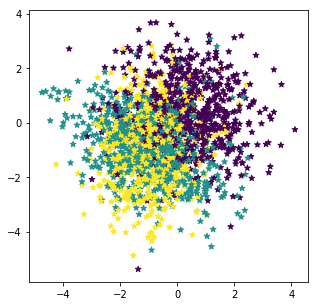

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import paddle

# 固定随机种子，保持每次运行结果一致
paddle.seed(102)
# 采样1000个样本
n_samples = 2000
X, y = make_multiclass_classification(n_samples=n_samples, n_features=5, n_classes=3, noise=0.1)

# 可视化生产的数据集，不同颜色代表不同类别
plt.figure(figsize=(5,5))
plt.scatter(x=X[:, 0].tolist(), y=X[:, 1].tolist(), marker='*', c=y.tolist())
plt.savefig('linear-dataset-vis2.pdf')
plt.show()

In [3]:
num_train = 1280
num_dev = 320
num_test = 400

X_train, y_train = X[:num_train], y[:num_train]
X_dev, y_dev = X[num_train:num_train + num_dev], y[num_train:num_train + num_dev]
X_test, y_test = X[num_train + num_dev:], y[num_train + num_dev:]

# 打印X_train和y_train的维度
print("X_train shape: ", X_train.shape, "y_train shape: ", y_train.shape)

X_train shape:  [1280, 5] y_train shape:  [1280]


In [4]:
from nndl import op
from abc import abstractmethod
import math

# 优化器基类
class Optimizer(object):
    def __init__(self, init_lr, model):
        """
        优化器类初始化
        """
        # 初始化学习率，用于参数更新的计算
        self.init_lr = init_lr
        # 指定优化器需要优化的模型
        self.model = model

    @abstractmethod
    def step(self):
        """
        定义每次迭代如何更新参数
        """
        pass

# 自定义余弦调度器
class CosineScheduler:
    def __init__(self, max_update, base_lr=0.01, final_lr=0,
               warmup_steps=0, warmup_begin_lr=0):
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps

    def get_warmup_lr(self, epoch):
        increase = (self.base_lr_orig - self.warmup_begin_lr) \
                       * float(epoch) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase

    def __call__(self, epoch):
        if epoch < self.warmup_steps:
            return self.get_warmup_lr(epoch)
        if epoch <= self.max_update:
            self.base_lr = self.final_lr + (
                self.base_lr_orig - self.final_lr) * (1 + math.cos(
                math.pi * (epoch - self.warmup_steps) / self.max_steps)) / 2
        return self.base_lr

class SimpleBatchGD(Optimizer):
    def __init__(self, init_lr, model):
        super(SimpleBatchGD, self).__init__(init_lr=init_lr, model=model)
        self.lr = init_lr
        # self.scheduler = CosineScheduler(max_update=20, base_lr=init_lr, final_lr=0.001)
    
    def set_lr(self, received_lr):
        self.lr = received_lr

    def step(self):
        # 参数更新
        # 遍历所有参数，按照公式(3.8)和(3.9)更新参数
        if isinstance(self.model.params, dict):
            for key in self.model.params.keys():
                self.model.params[key] = self.model.params[key] - self.lr * self.model.grads[key]

#######################################################################################################################################

# 用RunnerV2类封装整个训练过程
class RunnerV2(object):
    def __init__(self, model, optimizer, metric, loss_fn):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.metric = metric
        # 记录训练过程中的评价指标变化情况
        self.train_scores = []
        self.dev_scores = []
        # 记录训练过程中的损失函数变化情况
        self.train_loss = []
        self.dev_loss = []

        self.scheduler = CosineScheduler(max_update=500, base_lr=optimizer.lr, final_lr=0.001)

    def train(self, train_set, dev_set, **kwargs):
        # 传入训练轮数，如果没有传入值则默认为0
        num_epochs = kwargs.get("num_epochs", 0)
        # 传入log打印频率，如果没有传入值则默认为100
        log_epochs = kwargs.get("log_epochs", 100)
        # 传入模型保存路径，如果没有传入值则默认为"best_model.pdparams"
        save_path = kwargs.get("save_path", "best_model.pdparams")
        # 梯度打印函数，如果没有传入则默认为"None"
        print_grads = kwargs.get("print_grads", None)
        # 记录全局最优指标
        best_score = 0
        # 进行num_epochs轮训练
        for epoch in range(num_epochs):
            X, y = train_set
            # 获取模型预测
            logits = self.model(X)
            # 计算交叉熵损失
            trn_loss = self.loss_fn(logits, y).item()
            self.train_loss.append(trn_loss)
            # 计算评价指标
            trn_score = self.metric(logits, y).item()
            self.train_scores.append(trn_score)
            # 计算参数梯度
            self.model.backward(y)
            if print_grads is not None:
                # 打印每一层的梯度
                print_grads(self.model)
            # 更新模型参数
            self.optimizer.step()
            # print(self.scheduler(epoch))
            self.optimizer.set_lr(self.scheduler(epoch))

            dev_score, dev_loss = self.evaluate(dev_set)
            # 如果当前指标为最优指标，保存该模型
            if dev_score > best_score:
                self.save_model(save_path)
                print(f"best accuracy performence has been updated: {best_score:.5f} --> {dev_score:.5f}")
                best_score = dev_score
            if epoch % log_epochs == 0:
                print(f"[Train] epoch: {epoch}, loss: {trn_loss}, score: {trn_score}")
                print(f"[Dev] epoch: {epoch}, loss: {dev_loss}, score: {dev_score}")
            
            
                
    def evaluate(self, data_set):
        X, y = data_set
        # 计算模型输出
        logits = self.model(X)
        # 计算损失函数
        loss = self.loss_fn(logits, y).item()
        self.dev_loss.append(loss)
        # 计算评价指标
        score = self.metric(logits, y).item()
        self.dev_scores.append(score)
        return score, loss

    def predict(self, X):
        return self.model(X)

    def save_model(self, save_path):
        paddle.save(self.model.params, save_path)

    def load_model(self, model_path):
        self.model.params = paddle.load(model_path)

class model_SR(op.Op):
    def __init__(self, input_dim, output_dim):
        super(model_SR, self).__init__()
        self.params = {}
        # 将线性层的权重参数全部初始化为0
        self.params['W'] = paddle.zeros(shape=[input_dim, output_dim])
        # self.params['W'] = paddle.normal(mean=0, std=0.01, shape=[input_dim, output_dim])
        # 将线性层的偏置参数初始化为0
        self.params['b'] = paddle.zeros(shape=[output_dim])
        # 存放参数的梯度
        self.grads = {}
        self.X = None
        self.outputs = None
        self.output_dim = output_dim

    def __call__(self, inputs):
        return self.forward(inputs)

    def forward(self, inputs):
        self.X = inputs
        # 线性计算
        score = paddle.matmul(self.X, self.params['W']) + self.params['b']
        # Softmax 函数
        self.outputs = softmax(score)
        return self.outputs

    def backward(self, labels):
        """
        输入：
            - labels：真实标签，shape=[N, 1]，其中N为样本数量
        """
        # 计算偏导数
        N =labels.shape[0]
        labels = paddle.nn.functional.one_hot(labels, self.output_dim)
        self.grads['W'] = -1 / N * paddle.matmul(self.X.t(), (labels-self.outputs))
        self.grads['b'] = -1 / N * paddle.matmul(paddle.ones(shape=[N]), (labels-self.outputs))

class MultiCrossEntropyLoss(op.Op):
    def __init__(self):
        self.predicts = None
        self.labels = None
        self.num = None

    def __call__(self, predicts, labels):
        return self.forward(predicts, labels)

    def forward(self, predicts, labels):
        """
        输入：
            - predicts：预测值，shape=[N, 1]，N为样本数量
            - labels：真实标签，shape=[N, 1]
        输出：
            - 损失值：shape=[1]
        """
        self.predicts = predicts
        self.labels = labels
        self.num = self.predicts.shape[0]
        loss = 0
        for i in range(0, self.num):
            index = self.labels[i]
            loss -= paddle.log(self.predicts[i][index])
        return loss / self.num

def accuracy(preds, labels):
    """
    输入：
        - preds：预测值，二分类时，shape=[N, 1]，N为样本数量，多分类时，shape=[N, C]，C为类别数量
        - labels：真实标签，shape=[N, 1]
    输出：
        - 准确率：shape=[1]
    """
    # 判断是二分类任务还是多分类任务，preds.shape[1]=1时为二分类任务，preds.shape[1]>1时为多分类任务
    if preds.shape[1] == 1:
        # 二分类时，判断每个概率值是否大于0.5，当大于0.5时，类别为1，否则类别为0
        # 使用'paddle.cast'将preds的数据类型转换为float32类型
        preds = paddle.cast((preds>=0.5),dtype='float32')
    else:
        # 多分类时，使用'paddle.argmax'计算最大元素索引作为类别
        preds = paddle.argmax(preds,axis=1, dtype='int32')
    return paddle.mean(paddle.cast(paddle.equal(preds, labels),dtype='float32'))

# x为tensor
def softmax(X):
    """
    输入：
        - X：shape=[N, C]，N为向量数量，C为向量维度
    """
    x_max = paddle.max(X, axis=1, keepdim=True)#N,1
    x_exp = paddle.exp(X - x_max)
    partition = paddle.sum(x_exp, axis=1, keepdim=True)#N,1
    return x_exp / partition

y_pred: Tensor(shape=[2, 1], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [[-7.15093279],
        [ 3.71817803]])


In [5]:
# 固定随机种子，保持每次运行结果一致
paddle.seed(102)

# 特征维度
input_dim = 5
# 类别数
output_dim = 3
# 学习率
lr = 0.42

# 实例化模型
model = model_SR(input_dim=input_dim, output_dim=output_dim)
# 指定优化器
optimizer = SimpleBatchGD(init_lr=lr, model=model)
# 指定损失函数
loss_fn = MultiCrossEntropyLoss()
# 指定评价方式
metric = accuracy
# 实例化RunnerV2类
runner = RunnerV2(model, optimizer, metric, loss_fn)

# 模型训练
runner.train([X_train, y_train], [X_dev, y_dev], num_epochs=1000, log_eopchs=50, eval_epochs=1, save_path="best_model.pdparams")

best accuracy performence has been updated: 0.00000 --> 0.67813
[Train] epoch: 0, loss: 1.0986238718032837, score: 0.3359375
[Dev] epoch: 0, loss: 0.8988093733787537, score: 0.6781250238418579
best accuracy performence has been updated: 0.67813 --> 0.68750
best accuracy performence has been updated: 0.68750 --> 0.70000
best accuracy performence has been updated: 0.70000 --> 0.70312
best accuracy performence has been updated: 0.70312 --> 0.70625
best accuracy performence has been updated: 0.70625 --> 0.71250
best accuracy performence has been updated: 0.71250 --> 0.71875
best accuracy performence has been updated: 0.71875 --> 0.72500
best accuracy performence has been updated: 0.72500 --> 0.72813
best accuracy performence has been updated: 0.72813 --> 0.73125
best accuracy performence has been updated: 0.73125 --> 0.73438
best accuracy performence has been updated: 0.73438 --> 0.74063
[Train] epoch: 100, loss: 0.6492401361465454, score: 0.7593750357627869
[Dev] epoch: 100, loss: 0.69646

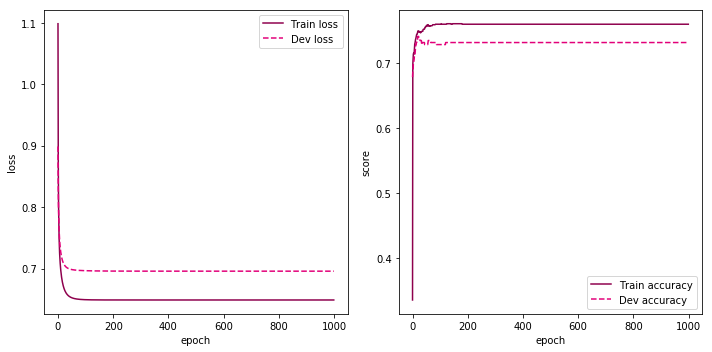

In [6]:
def plot(runner,fig_name):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    epochs = [i for i in range(len(runner.train_scores))]
    # 绘制训练损失变化曲线
    plt.plot(epochs, runner.train_loss, color='#8E004D', label="Train loss")
    # 绘制评价损失变化曲线
    plt.plot(epochs, runner.dev_loss, color='#E20079', linestyle='--', label="Dev loss")
    # 绘制坐标轴和图例
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(loc='upper right')
    plt.subplot(1,2,2)
    # 绘制训练准确率变化曲线
    plt.plot(epochs, runner.train_scores, color='#8E004D', label="Train accuracy")
    # 绘制评价准确率变化曲线
    plt.plot(epochs, runner.dev_scores, color='#E20079', linestyle='--', label="Dev accuracy")
    # 绘制坐标轴和图例
    plt.ylabel("score")
    plt.xlabel("epoch")
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig(fig_name)
    plt.show()

# 可视化观察训练集与验证集的准确率变化情况
plot(runner,fig_name='linear-acc2.pdf')

In [7]:
score, loss = runner.evaluate([X_test, y_test])
print("[Test] score/loss: {:.4f}/{:.4f}".format(score, loss))

[Test] score/loss: 0.7600/0.6441


**注**：

在实现时定义了一个余弦学习率调度器即`CosineScheduler`类，实例化后在`RunnerV2`类的`train`方法中调用，通过在`SimpleBatchGD`类里添加的`set_lr`方法，每训练完一个epoch，就根据学习率调度器动态地调整梯度下降的学习率，每当进展趋于稳定时就降低学习率。

通过traning curve也可以观察到，在训练期间逐步降低学习率可以提高准确性，并且减少模型的过拟合。

### 2.某家公司正在设计一个根据手机识别的数据来预测人类行为的系统。小明作为该公司的实习生参与了该项目，并打算使用softmax回归进行训练。他们挑选了30名志愿者，每个人在腰部佩戴某品牌的智能手机进行六项活动（步行、楼上步行、楼下步行、坐、站、躺），并捕获手机的3轴线性加速度和3轴角速度，希望通过得到的数据判断是在进行哪一种活动。小明使用全部数据进行训练，经过认真调参，模型很好的拟合了这些数据。小明打算将其直接用于实际使用中，请问这种训练方式是否正确，存在什么问题。<span style="color:red">(附加题&简答题&加分题)</span>

我认为这种训练方式**不太正确**。

- 采用全部数据进行训练，那么模型的验证、测试必然在训练数据或训练数据的子集上进行，不符合机器学习的原则，即使在验证和测试中，观察到模型的拟合能力良好，也无法证明该模型有良好的泛化能力。
- 志愿者数量只有30名，可能依然存在data hungry问题，并且手机用户的年龄、身体状况存在多样性，选择志愿者、训练数据时也应该注意对年龄段或其他特征进行分层抽样。
- softamax回归相当于仅有一层的MLP，模型容量可能不足。